In [28]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from numpy import array
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
def read_data(name):
    file = open(name)
    string = file.read()
    return string

In [3]:
data1 = read_data('pg31100.txt') 
raw_text = ([i.replace("\n"," ") for i in data1.split('\n\n') if len(i.split()) > 25][1:])
print(raw_text)
data_frame = []
for i in raw_text:
    data_frame.append(i.lower())
df = pd.DataFrame(data_frame,columns = ['Text'])
df['Label'] = 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
data2 = read_data('pg1661.txt') 
raw_text1 = ([i.replace("\n"," ") for i in data2.split('\n\n') if len(i.split()) > 25][1:])
data_frame = []
for i in raw_text1:
    data_frame.append(i.lower())
df1 = pd.DataFrame(data_frame,columns = ['Text'])
df1['Label'] = 1
len(df1)

1160

In [5]:
data3 = read_data('28054-0.txt') 
raw_text2 = ([i.replace("\n"," ") for i in data3.split('\n\n') if len(i.split()) > 25][1:])
data_frame = []
for i in raw_text2:
    data_frame.append(i.lower())
df2 = pd.DataFrame(data_frame,columns = ['Text'])
df2['Label'] = 2
len(df2)

3002

In [21]:
frames = [df,df1,df2]
dataset = pd.concat(frames, axis=0, sort=False,ignore_index = True)
dataset.shape

(11449, 2)

from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(dataset,test_size=0.3)

In [8]:
def create_tokens(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)  #removes punctuations using 
    tokens = [w.translate(table) for w in tokens] #dictionary of punctuations
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word)>2]
    return tokens

In [9]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aviratbelekar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
words = set()
vocab = {}

token = dataset['Text'][0].split()
table = str.maketrans('','',punctuation)
tokens = [w.translate(table) for w in token] 
print(len(tokens))
tokens = [word for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
tokens = [word for word in tokens if len(word)>2]
#print(tokens)

113


In [11]:
documents = dataset['Text']
for doc in documents:
    tokens = create_tokens(doc)
    for token in tokens:
        if token in vocab:
            vocab[token] += 1
        else:
            vocab[token] = 1
print(len(vocab))

for word in vocab:
    if vocab[word] > 5:
        words.add(word)

print(len(words))

25815
7687


In [12]:
train_documents = []
for doc in train_data['Text']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    train_documents.append(final_string)

test_documents = []
for doc in test_data['Text']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    test_documents.append(final_string)


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)
encoded_docs = tokenizer.texts_to_sequences(train_documents)
labels = train_data['Label']
max_length = max(([len(s.split()) for s in train_documents]))
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytrain = keras.utils.to_categorical(labels, num_classes=3)
print(Xtrain.shape)
print(ytrain.shape)

(8014, 804)
(8014, 3)


In [14]:
encoded_docs = tokenizer.texts_to_sequences(test_documents)
labels = test_data['Label']
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytest = keras.utils.to_categorical(labels, num_classes=3)
print(Xtest.shape)
print(ytest.shape)

(3435, 804)
(3435, 3)


In [15]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_length))
model.add(Conv1D(filters= 16, kernel_size= 16, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
print(model.summary())

3
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 804, 100)          300       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 789, 16)           25616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 394, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 375, 20)           6420      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 187, 20)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3740)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3740)           

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(Xtrain, ytrain, epochs=5,verbose=2, validation_data = (Xtest,ytest))

/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8014 samples, validate on 3435 samples
Epoch 1/5
 - 46s - loss: 0.8717 - accuracy: 0.6339 - val_loss: 0.8743 - val_accuracy: 0.6425
Epoch 2/5
 - 42s - loss: 0.8722 - accuracy: 0.6339 - val_loss: 0.8736 - val_accuracy: 0.6425
Epoch 3/5
 - 43s - loss: 0.8712 - accuracy: 0.6339 - val_loss: 0.8759 - val_accuracy: 0.6425
Epoch 4/5
 - 44s - loss: 0.8715 - accuracy: 0.6339 - val_loss: 0.8789 - val_accuracy: 0.6425
Epoch 5/5
 - 153s - loss: 0.8715 - accuracy: 0.6339 - val_loss: 0.8740 - val_accuracy: 0.6425


In [31]:
random_text = ["shortly after getting his four‐year‐old Mitya"]
encoded_text = tokenizer.texts_to_sequences(test_documents)
test_text = pad_sequences(encoded_text, maxlen = max_length, padding= 'post')
model.predict(test_text)

array([[0.6123086 , 0.11002879, 0.27766258],
       [0.6123086 , 0.11002879, 0.27766258],
       [0.6123086 , 0.11002879, 0.27766258],
       ...,
       [0.6123086 , 0.11002879, 0.27766258],
       [0.6123086 , 0.11002879, 0.27766258],
       [0.6123086 , 0.11002879, 0.27766255]], dtype=float32)

In [32]:
ypred = model.predict(Xtest)
print(ypred)
pred_labels = []
for probs in ypred:
    label = np.argmax(probs, axis=-1)
    pred_labels.append(int(label))
#print(pred_labels)
actual_labels = list(labels)

[[0.6123086  0.11002879 0.27766258]
 [0.6123086  0.11002879 0.27766258]
 [0.6123086  0.11002879 0.27766258]
 ...
 [0.6123086  0.11002879 0.27766258]
 [0.6123086  0.11002879 0.27766258]
 [0.6123086  0.11002879 0.27766255]]


In [33]:
accuracy = accuracy_score(actual_labels,pred_labels)
accuracy

0.6425036390101893

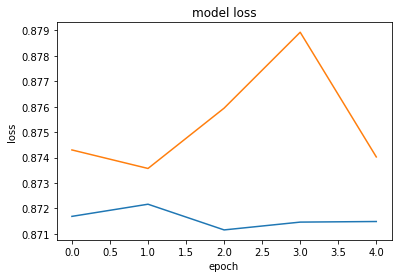

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()